# Load Data and Preprocessing

In [11]:
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Set the default DPI
plt.rcParams['figure.dpi'] = 100  

well_info = pd.read_csv('well-loc.tsv', sep='\t')

# Path to the sensor data directory
sensor_data_path = 'sensor-data'

# List all TSV files in the directory
sensor_data_files = [f for f in os.listdir(sensor_data_path) if f.endswith('.tsv')]

# Sort the sensor_data_files list
sensor_data_files.sort(key= lambda x: int(x.split('.')[0]))

# Load and concatenate all sensor data files into one DataFrame
sensor_data_list = [pd.read_csv(os.path.join(sensor_data_path, file), sep='\t',
                                na_values="-9999") for file in sensor_data_files]

# Remove the data point with NaN value
well_info = well_info.dropna()
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)

# Reset the index of the well_loc DataFrame to Well, X, Y
well_info.rename(columns={'井': 'Well'}, inplace=True)

# Reset the index of the sensor data DataFrame to Depth, Porosity, Hydrate Saturation
for idx, _ in enumerate(sensor_data_list):
	sensor_data_list[idx].columns = ['Depth', 'Porosity', 'Hydrate Saturation']

print(well_info.head())  # Display the first few rows to verify it's loaded correctly
print(sensor_data_list[0].head())  # Display the first few rows to verify it's loaded correctly

  Well      X      Y
0  w01  34500  45000
1  w02  36000  45050
2  w03  37050  45020
3  w04  37880  46000
4  w05  35000  46030
         Depth  Porosity  Hydrate Saturation
112  1832.0004    0.5236              0.0237
113  1832.1528    0.5208              0.0175
114  1832.3052    0.5196              0.0000
115  1832.4576    0.5156              0.0000
116  1832.6100    0.4971              0.0000


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the sensor data
scaler = MinMaxScaler()
for idx, sensor_data in enumerate(sensor_data_list):
    sensor_data[['Porosity', 'Hydrate Saturation']] = scaler.fit_transform(sensor_data[['Porosity', 'Hydrate Saturation']])

# Estimate Resource Distribution

In [13]:
def estimate_resource(sensor_data: pd.Series) -> float:
	"""Estimate the resource at a given location based on sensor data"""
	# Get the Porosity and the Hydrate saturation
	porosity = sensor_data['Porosity']
	hydrate_saturation = sensor_data['Hydrate Saturation']

	valid_volume = 1 # Assume the valid volume is 1 cubic meter
	factor = 155 # Assume the factor is 155

	# Calculate the resource estimate
	return valid_volume * porosity * hydrate_saturation * factor

In [14]:
# Calculate the resource estimate for each sensor data in each depth
for idx, sensor_data in enumerate(sensor_data_list):
    sensor_data_list[idx]['Estimated Resources'] = sensor_data.apply(estimate_resource, axis=1)

sensor_data_list[0]

,Depth,Porosity,Hydrate Saturation,Estimated Resources
112,1832.0004,0.619070,0.266592,25.581030
113,1832.1528,0.605918,0.196850,18.487664
114,1832.3052,0.600282,0.000000,0.000000
115,1832.4576,0.581494,0.000000,0.000000
116,1832.6100,0.494598,0.000000,0.000000
...,...,...,...,...
1716,2076.4500,0.268201,0.000000,0.000000
1717,2076.6024,0.393612,0.000000,0.000000
1718,2076.7548,0.337248,0.000000,0.000000
1719,2076.9072,0.357915,0.000000,0.000000


In [21]:
resource_sums = [df['Estimated Resources'].sum() for df in sensor_data_list]
well_info['Total Resources'] = resource_sums

# Kriging 3D Interpolation

### Define Functions

In [23]:
def compose_krige3D(name: str, sample_frac: float, step_sizes: tuple, variogram: str):
    from pykrige.ok3d import OrdinaryKriging3D

    # Make kriging interpolation for Porosity  individually
    data_frames = []
    for i, df in enumerate(sensor_data_list):
        df['X'] = well_info.loc[i, 'X']
        df['Y'] = well_info.loc[i, 'Y']
        df['Well'] = well_info.loc[i, 'Well']
        df['Total Resources'] = well_info.loc[i, 'Total Resources']
        data_frames.append(df)

    combined_data = pd.concat(data_frames, ignore_index=True)

    sampled_data = combined_data.sample(frac=sample_frac, random_state=1)  # random_state for reproducibility

    X = sampled_data['X'].values
    Y = sampled_data['Y'].values
    Z = sampled_data['Depth'].values
    values = sampled_data[name].values

    # Create the 3D Kriging model
    ok3d = OrdinaryKriging3D(
        X,
        Y,
        Z,
        values,
        variogram_model=variogram,  # You might need to experiment with different models
        verbose=True,
        enable_plotting=True,
    )
    
    # Define grid points for interpolation
    grid_x = np.arange(min(X)-200, max(X)+200, step_sizes[0])
    grid_y = np.arange(min(Y)-200, max(Y)+200, step_sizes[1])
    grid_z = np.arange(min(Z)-1, max(Z)+1, step_sizes[2])

    return ok3d, (grid_x, grid_y, grid_z)

In [18]:
def plot_3D_mesh(t, grid_x, grid_y, grid_z, title: str):
    GZ, GY, GX = np.meshgrid(grid_z, grid_y, grid_x, indexing='ij')
    print(GX.shape, GY.shape, GZ.shape)  # 应该输出 (12, 108, 88) 或类似，取决于具体的 grid_x, grid_y, grid_z

    fig = go.Figure(
        data=[go.Volume(
            x=GX.flatten(),
            y=GY.flatten(),
            z=GZ.flatten(),
            value=t.flatten(),
            isomin=t.min(),
            isomax=t.max(),
            opacity=0.5,  # Adjust the opacity to your liking
            surface_count=15,  # Adjust the number of isosurfaces
        )])

    # Update the layout of the plot
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis=dict(
                title='Depth',
                autorange='reversed'  # Automatically reverse the z-axis
            )
        )
    )

    # Show the plot
    fig.show()

### Kriging Interpolation of Total Resources

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 261.8478391263554
Full Sill: 601.9528437932421
Range: 656.4333487739669
Nugget: 340.1050046668867 



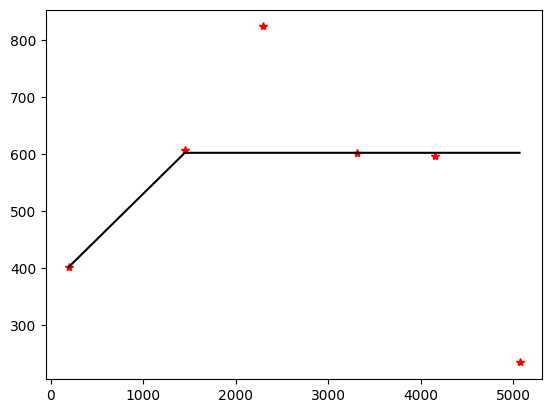

Calculating statistics on variogram model fit...


In [26]:
ok3d, grid = compose_krige3D("Estimated Resources", 1.0, (10, 10, 1), 'gaussian')

In [ ]:
t_res, ss3d_res = ok3d.execute('grid', *grid)

In [ ]:
plot_3D_mesh(t_res, *grid, "Kriging Interpolation of Total Resources")
plot_3D_mesh(ss3d_res, *grid, "Kriging Varience of Total Resources")

### Kriging Interpolation of Porosity

In [ ]:
ok3d, grid = compose_krige3D("Porosity", 1.0, (10, 10, 1), 'linear')

In [ ]:
t_poro, ss3d_poro = ok3d.execute('grid', *grid)

In [ ]:
plot_3D_mesh(t_res, *grid, "Kriging Interpolation of Porosity")
plot_3D_mesh(ss3d_poro, *grid, "Kriging Varience of Porosity")

### Kriging Interpolation of Hydrate Saturation

In [ ]:
ok3d, grid = compose_krige3D("Hydrate Saturation", 1.0, (10, 10, 1), 'linear')

In [ ]:
t_poro, ss3d_poro = ok3d.execute('grid', *grid)

In [ ]:
plot_3D_mesh(t_res, *grid, "Kriging Interpolation of Hydrate Saturation")
plot_3D_mesh(ss3d_poro, *grid, "Kriging Varience of Hydrate Saturation")